## Import

In [ ]:
!nvidia-smi

Thu Jul 27 00:31:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti    WDDM | 00000000:2B:00.0  On |                  N/A |
|  0%   39C    P8               19W / 400W|    621MiB / 12288MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet
import timm

import time
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


## Utils

In [ ]:
# def min_max(img):
#     return (img - img.min()) / (img.max() - img.min())

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [ ]:
train_transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ]),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join('C:/Users/ghtyu/Kyeong6/contest_data',self.data.iloc[idx, 1])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [ ]:
# fig, axs = plt.subplots(8,8,figsize=(20,20))
# for i in range(8):
#     for j in range(8):
#         axs[i][j].imshow(cv2.imread(f'C:/Users/ghtyu/Kyeong6/contest_data/test_img/TEST_{i*8+j+256:05d}.png'))
#         axs[i][j].set_axis_off()

In [ ]:
dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=None)

In [ ]:
from torch.utils.data import random_split

# train data와 validation data를 나눌 비율 설정
train_ratio = 0.8
val_ratio = 0.2

# 데이터셋을 나누기 위한 길이 계산
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# 데이터셋을 나누기 전에 transform을 적용하여 train_dataset과 val_dataset 생성
train_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=train_transform)
val_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=val_transform)

# 데이터셋을 나누기 위해 random_split 함수 사용
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 각 데이터셋을 DataLoader로 변환
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

## Model Define

## Model Train

In [ ]:
# BCE + Dice Loss
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed 고정
seed = 121
seed_everything(seed)

In [ ]:
epochs = 100
lr = 0.001
reg = 1e-4

In [ ]:
model = smp.UnetPlusPlus(encoder_name='timm-efficientnet-b6',
             encoder_depth=5,
             encoder_weights='advprop',
             decoder_use_batchnorm=True,
             decoder_channels=(256, 128, 64, 32, 16),
             decoder_attention_type=None,
             in_channels=3,
             classes=1,
             activation=None,
             aux_params=None).to(device)


criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

In [ ]:
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

In [ ]:
# 학습 함수
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)

    return train_loss

# 검증 함수
def validate(model, dataloader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            val_loss += loss.item()

    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# 학습과정에서 손실 및 정확도 기록용 리스트
train_losses = []
val_losses = []

In [ ]:
# 학습 루프
for epoch in range(epochs):
    # 훈련 단계
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 검증 단계
    val_loss = validate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)

    # 학습률 스케줄링
    scheduler.step()

    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  0%|                                                                                          | 0/357 [00:00<?, ?it/s]C:\Users\ghtyu\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.11it/s]


Epoch 1: Train Loss: 0.6568, Val Loss: 0.4553


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 2: Train Loss: 0.4722, Val Loss: 0.4384


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 3: Train Loss: 0.4411, Val Loss: 0.4540


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 4: Train Loss: 0.4083, Val Loss: 0.3688


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 5: Train Loss: 0.4009, Val Loss: 0.3909


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 6: Train Loss: 0.3869, Val Loss: 0.3651


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 7: Train Loss: 0.3658, Val Loss: 0.3425


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 8: Train Loss: 0.3544, Val Loss: 0.3347


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 9: Train Loss: 0.3392, Val Loss: 0.3404


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 10: Train Loss: 0.3293, Val Loss: 0.3145


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 11: Train Loss: 0.4094, Val Loss: 0.4261


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 12: Train Loss: 0.4036, Val Loss: 0.3772


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 13: Train Loss: 0.3875, Val Loss: 0.3413


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 14: Train Loss: 0.3852, Val Loss: 0.3482


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 15: Train Loss: 0.3587, Val Loss: 0.3570


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 16: Train Loss: 0.3561, Val Loss: 0.3330


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 17: Train Loss: 0.3323, Val Loss: 0.3160


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.20it/s]


Epoch 18: Train Loss: 0.3367, Val Loss: 0.3112


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 19: Train Loss: 0.3258, Val Loss: 0.3112


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 20: Train Loss: 0.3089, Val Loss: 0.2955


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 21: Train Loss: 0.3903, Val Loss: 0.3870


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 22: Train Loss: 0.3806, Val Loss: 0.3973


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 23: Train Loss: 0.3723, Val Loss: 0.3574


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 24: Train Loss: 0.3707, Val Loss: 0.3530


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 25: Train Loss: 0.3640, Val Loss: 0.3478


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 26: Train Loss: 0.3513, Val Loss: 0.3279


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 27: Train Loss: 0.3357, Val Loss: 0.3152


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 28: Train Loss: 0.3152, Val Loss: 0.3128


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 29: Train Loss: 0.3048, Val Loss: 0.2962


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 30: Train Loss: 0.3106, Val Loss: 0.3003


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 31: Train Loss: 0.3791, Val Loss: 0.3788


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 32: Train Loss: 0.3766, Val Loss: 0.3846


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 33: Train Loss: 0.3637, Val Loss: 0.3827


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 34: Train Loss: 0.3718, Val Loss: 0.3585


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 35: Train Loss: 0.3609, Val Loss: 0.3496


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 36: Train Loss: 0.3547, Val Loss: 0.3264


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 37: Train Loss: 0.3300, Val Loss: 0.3222


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 38: Train Loss: 0.3086, Val Loss: 0.3092


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 39: Train Loss: 0.3120, Val Loss: 0.2891


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 40: Train Loss: 0.3012, Val Loss: 0.3000


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 41: Train Loss: 0.3585, Val Loss: 0.3683


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 42: Train Loss: 0.3692, Val Loss: 0.3465


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 43: Train Loss: 0.3589, Val Loss: 0.3534


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 44: Train Loss: 0.3626, Val Loss: 0.3467


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 45: Train Loss: 0.3514, Val Loss: 0.3407


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 46: Train Loss: 0.3367, Val Loss: 0.3201


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 47: Train Loss: 0.3284, Val Loss: 0.3183


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 48: Train Loss: 0.3175, Val Loss: 0.3077


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 49: Train Loss: 0.3080, Val Loss: 0.3083


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 50: Train Loss: 0.3055, Val Loss: 0.3019


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 51: Train Loss: 0.3692, Val Loss: 0.3439


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 52: Train Loss: 0.3595, Val Loss: 0.3570


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 53: Train Loss: 0.3507, Val Loss: 0.3358


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 54: Train Loss: 0.3514, Val Loss: 0.3482


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 55: Train Loss: 0.3447, Val Loss: 0.3271


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 56: Train Loss: 0.3410, Val Loss: 0.3273


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 57: Train Loss: 0.3195, Val Loss: 0.3190


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 58: Train Loss: 0.3234, Val Loss: 0.2992


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 59: Train Loss: 0.3060, Val Loss: 0.2968


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 60: Train Loss: 0.3033, Val Loss: 0.3001


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 61: Train Loss: 0.3668, Val Loss: 0.3429


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 62: Train Loss: 0.3727, Val Loss: 0.3605


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 63: Train Loss: 0.3593, Val Loss: 0.3492


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 64: Train Loss: 0.3529, Val Loss: 0.3250


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 65: Train Loss: 0.3428, Val Loss: 0.3212


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 66: Train Loss: 0.3325, Val Loss: 0.3313


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 67: Train Loss: 0.3277, Val Loss: 0.3130


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 68: Train Loss: 0.3169, Val Loss: 0.3208


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 69: Train Loss: 0.3097, Val Loss: 0.2934


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 70: Train Loss: 0.3008, Val Loss: 0.3025


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 71: Train Loss: 0.3478, Val Loss: 0.3506


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 72: Train Loss: 0.3696, Val Loss: 0.3464


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 73: Train Loss: 0.3618, Val Loss: 0.3540


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 74: Train Loss: 0.3538, Val Loss: 0.3401


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 75: Train Loss: 0.3397, Val Loss: 0.3991


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 76: Train Loss: 0.3333, Val Loss: 0.3340


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 77: Train Loss: 0.3256, Val Loss: 0.3181


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 78: Train Loss: 0.3066, Val Loss: 0.3070


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 79: Train Loss: 0.3005, Val Loss: 0.2971


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 80: Train Loss: 0.3055, Val Loss: 0.2985


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 81: Train Loss: 0.3608, Val Loss: 0.3507


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 82: Train Loss: 0.3599, Val Loss: 0.3255


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 83: Train Loss: 0.3786, Val Loss: 0.3559


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 84: Train Loss: 0.3377, Val Loss: 0.3281


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 85: Train Loss: 0.3418, Val Loss: 0.3297


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 86: Train Loss: 0.3233, Val Loss: 0.3183


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 87: Train Loss: 0.3150, Val Loss: 0.3159


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 88: Train Loss: 0.3219, Val Loss: 0.3193


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 89: Train Loss: 0.3030, Val Loss: 0.3152


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 90: Train Loss: 0.3009, Val Loss: 0.2990


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 91: Train Loss: 0.3660, Val Loss: 0.3326


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 92: Train Loss: 0.3649, Val Loss: 0.3822


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 93: Train Loss: 0.3559, Val Loss: 0.4008


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 94: Train Loss: 0.3666, Val Loss: 0.3383


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 95: Train Loss: 0.3413, Val Loss: 0.3247


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 96: Train Loss: 0.3282, Val Loss: 0.3110


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 97: Train Loss: 0.3150, Val Loss: 0.3350


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 98: Train Loss: 0.3133, Val Loss: 0.3134


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 99: Train Loss: 0.3000, Val Loss: 0.2924


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 100: Train Loss: 0.2990, Val Loss: 0.3100


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 101: Train Loss: 0.3457, Val Loss: 0.3343


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 102: Train Loss: 0.3453, Val Loss: 0.3559


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 103: Train Loss: 0.3420, Val Loss: 0.3355


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 104: Train Loss: 0.3489, Val Loss: 0.3402


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 105: Train Loss: 0.3401, Val Loss: 0.3360


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 106: Train Loss: 0.3264, Val Loss: 0.3124


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 107: Train Loss: 0.3145, Val Loss: 0.3168


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 108: Train Loss: 0.3080, Val Loss: 0.2898


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 109: Train Loss: 0.3021, Val Loss: 0.2974


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 110: Train Loss: 0.3043, Val Loss: 0.2904


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 111: Train Loss: 0.3638, Val Loss: 0.3759


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 112: Train Loss: 0.3786, Val Loss: 0.3477


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 113: Train Loss: 0.3467, Val Loss: 0.3373


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 114: Train Loss: 0.3364, Val Loss: 0.3445


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 115: Train Loss: 0.3437, Val Loss: 0.3231


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 116: Train Loss: 0.3356, Val Loss: 0.3277


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 117: Train Loss: 0.3178, Val Loss: 0.3002


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 118: Train Loss: 0.3161, Val Loss: 0.3208


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 119: Train Loss: 0.3000, Val Loss: 0.3054


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 120: Train Loss: 0.2937, Val Loss: 0.2959


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 121: Train Loss: 0.3453, Val Loss: 0.3323


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 122: Train Loss: 0.3557, Val Loss: 0.3473


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 123: Train Loss: 0.3444, Val Loss: 0.3287


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 124: Train Loss: 0.3382, Val Loss: 0.3222


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 125: Train Loss: 0.3392, Val Loss: 0.3188


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 126: Train Loss: 0.3251, Val Loss: 0.3334


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 127: Train Loss: 0.3232, Val Loss: 0.3063


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 128: Train Loss: 0.3107, Val Loss: 0.2981


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 129: Train Loss: 0.3013, Val Loss: 0.2981


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 130: Train Loss: 0.2943, Val Loss: 0.2956


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 131: Train Loss: 0.3499, Val Loss: 0.3213


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.23it/s]


Epoch 132: Train Loss: 0.3480, Val Loss: 0.3539


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:43<00:00,  2.08it/s]


Epoch 133: Train Loss: 0.3468, Val Loss: 0.3386


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.11it/s]


Epoch 134: Train Loss: 0.3548, Val Loss: 0.3254


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.14it/s]


Epoch 135: Train Loss: 0.3375, Val Loss: 0.3182


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 136: Train Loss: 0.3283, Val Loss: 0.3147


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:47<00:00,  1.91it/s]


Epoch 137: Train Loss: 0.3147, Val Loss: 0.2926


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.25it/s]


Epoch 138: Train Loss: 0.3139, Val Loss: 0.2957


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 139: Train Loss: 0.2971, Val Loss: 0.2861


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 140: Train Loss: 0.3001, Val Loss: 0.2969


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 141: Train Loss: 0.3610, Val Loss: 0.3534


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 142: Train Loss: 0.3642, Val Loss: 0.3624


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 143: Train Loss: 0.3369, Val Loss: 0.3339


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 144: Train Loss: 0.3349, Val Loss: 0.3120


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.14it/s]


Epoch 145: Train Loss: 0.3428, Val Loss: 0.3371


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:41<00:00,  2.15it/s]


Epoch 146: Train Loss: 0.3171, Val Loss: 0.3204


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.14it/s]


Epoch 147: Train Loss: 0.3137, Val Loss: 0.3046


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.12it/s]


Epoch 148: Train Loss: 0.3043, Val Loss: 0.3043


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:42<00:00,  2.12it/s]


Epoch 149: Train Loss: 0.3073, Val Loss: 0.2957


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:43<00:00,  2.08it/s]

Epoch 150: Train Loss: 0.3028, Val Loss: 0.2957


In [ ]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))

    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

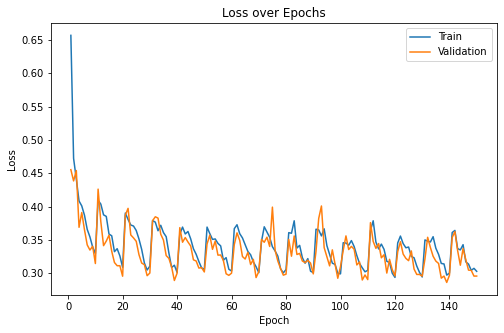

In [ ]:
# 손실 그래프만 표시
plot_loss(train_losses, val_losses)

## Inference

In [ ]:
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
test_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/test.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████████████████████████████████████████████████████████████████████████| 3790/3790 [08:55<00:00,  7.08it/s]


## Submission

In [ ]:
submit = pd.read_csv('C:/Users/ghtyu/Kyeong6/contest_data/sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('C:/Users/ghtyu/Kyeong6/k_submit_0727_2.csv', index=False)